In [5]:
import simpy
import numpy as np
import csv
import pandas as pd

# Parameters for the simulation
NUM_DOCTORS = 3
TRIAGE_TIME = 5
DOCTOR_TIME_MEAN = 15
SIM_TIME = 480  # 8 hours of simulation
ARRIVAL_RATE = 10  # Average 1 patient every 10 minutes

# Function to reset and write data to the CSV file
def reset_csv():
    with open('patient_data.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Arrival_Time', 'Triage_Time', 'Doctor_Consultation_Time', 'Total_Wait_Time'])

# Track wait times and patient data
def track_wait(arrival_time, triage_time, doctor_time, departure_time):
    total_wait_time = departure_time - arrival_time
    with open('patient_data.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([arrival_time, triage_time, doctor_time, total_wait_time])

# Simulate patient arrivals
def patient_arrivals(env, arrival_rate, hospital):
    while True:
        yield env.timeout(np.random.poisson(arrival_rate))
        env.process(hospital(env, env.now))

# Simulate hospital process
def hospital(env, arrival_time, doctor_resource):
    triage_time = TRIAGE_TIME
    yield env.timeout(triage_time)  # Triage process

    # Patient waits for a doctor
    with doctor_resource.request() as req:
        yield req
        doctor_time = np.random.exponential(DOCTOR_TIME_MEAN)
        yield env.timeout(doctor_time)  # Doctor consultation
        departure_time = env.now
        track_wait(arrival_time, triage_time, doctor_time, departure_time)

# Function to simulate the effect of adding more doctors on wait time
def optimize_doctors(num_doctors, arrival_rate):
    # Reset the CSV file for new simulation data
    reset_csv()

    # Setup the simulation environment with new number of doctors
    env = simpy.Environment()
    doctor_resource = simpy.Resource(env, capacity=num_doctors)

    # Run the simulation again
    env.process(patient_arrivals(env, arrival_rate, lambda env, arrival_time: hospital(env, arrival_time, doctor_resource)))
    env.run(until=SIM_TIME)

    # Load the updated patient data
    patient_data = pd.read_csv('patient_data.csv')

    # Check if the data is empty and prevent errors
    if patient_data.empty:
        print(f"No data generated for {num_doctors} doctors.")
        return None

    # Calculate new average wait time
    avg_wait_time = patient_data['Total_Wait_Time'].mean()

    # Handle case where calculation results in NaN
    if pd.isna(avg_wait_time):
        print(f"Invalid data for {num_doctors} doctors.")
        return None

    return avg_wait_time

# Try different doctor capacities and analyze the results
doctor_counts = [3, 5, 7, 10]
for num_doctors in doctor_counts:
    avg_wait_time = optimize_doctors(num_doctors, ARRIVAL_RATE)
    if avg_wait_time is not None:
        print(f"Avg wait time with {num_doctors} doctors: {avg_wait_time:.2f} minutes")
    else:
        print(f"Could not compute avg wait time for {num_doctors} doctors.")


Avg wait time with 3 doctors: 19.09 minutes
Avg wait time with 5 doctors: 22.10 minutes
Avg wait time with 7 doctors: 15.50 minutes
Avg wait time with 10 doctors: 14.51 minutes


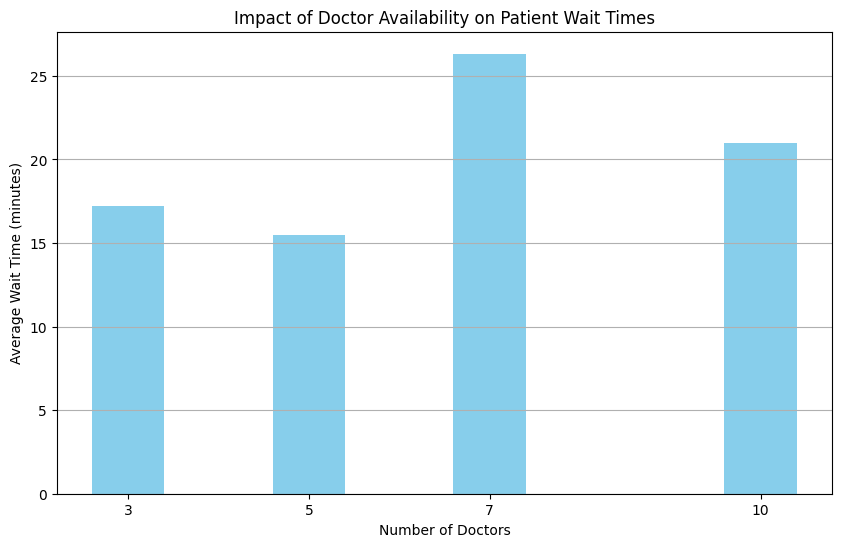

In [6]:
import simpy
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt

# Parameters for the simulation
NUM_DOCTORS = 3
TRIAGE_TIME = 5
DOCTOR_TIME_MEAN = 15
SIM_TIME = 480  # 8 hours of simulation
ARRIVAL_RATE = 10  # Average 1 patient every 10 minutes

# Function to reset and write data to the CSV file
def reset_csv():
    with open('patient_data.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Arrival_Time', 'Triage_Time', 'Doctor_Consultation_Time', 'Total_Wait_Time'])

# Track wait times and patient data
def track_wait(arrival_time, triage_time, doctor_time, departure_time):
    total_wait_time = departure_time - arrival_time
    with open('patient_data.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([arrival_time, triage_time, doctor_time, total_wait_time])

# Simulate patient arrivals
def patient_arrivals(env, arrival_rate, hospital):
    while True:
        yield env.timeout(np.random.poisson(arrival_rate))
        env.process(hospital(env, env.now))

# Simulate hospital process
def hospital(env, arrival_time, doctor_resource):
    triage_time = TRIAGE_TIME
    yield env.timeout(triage_time)  # Triage process

    # Patient waits for a doctor
    with doctor_resource.request() as req:
        yield req
        doctor_time = np.random.exponential(DOCTOR_TIME_MEAN)
        yield env.timeout(doctor_time)  # Doctor consultation
        departure_time = env.now
        track_wait(arrival_time, triage_time, doctor_time, departure_time)

# Function to simulate the effect of adding more doctors on wait time
def optimize_doctors(num_doctors, arrival_rate):
    # Reset the CSV file for new simulation data
    reset_csv()

    # Setup the simulation environment with new number of doctors
    env = simpy.Environment()
    doctor_resource = simpy.Resource(env, capacity=num_doctors)

    # Run the simulation again
    env.process(patient_arrivals(env, arrival_rate, lambda env, arrival_time: hospital(env, arrival_time, doctor_resource)))
    env.run(until=SIM_TIME)

    # Load the updated patient data
    patient_data = pd.read_csv('patient_data.csv')

    # Check if the data is empty and prevent errors
    if patient_data.empty:
        print(f"No data generated for {num_doctors} doctors.")
        return None

    # Calculate new average wait time
    avg_wait_time = patient_data['Total_Wait_Time'].mean()

    # Handle case where calculation results in NaN
    if pd.isna(avg_wait_time):
        print(f"Invalid data for {num_doctors} doctors.")
        return None

    return avg_wait_time

# Try different doctor capacities and analyze the results
doctor_counts = [3, 5, 7, 10]
avg_wait_times = []
for num_doctors in doctor_counts:
    avg_wait_time = optimize_doctors(num_doctors, ARRIVAL_RATE)
    if avg_wait_time is not None:
        avg_wait_times.append(avg_wait_time)
    else:
        avg_wait_times.append(np.nan)

# Visualization: Plotting the average wait times for different doctor counts
plt.figure(figsize=(10, 6))
plt.bar(doctor_counts, avg_wait_times, color='skyblue')
plt.xlabel('Number of Doctors')
plt.ylabel('Average Wait Time (minutes)')
plt.title('Impact of Doctor Availability on Patient Wait Times')
plt.xticks(doctor_counts)
plt.grid(True, axis='y')
plt.show()
